# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [1]:
# Imports
import os
import torch
import time
import random
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from torchvision import datasets, transforms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

In [2]:
# Reading the data and investigating
df = pd.read_csv('Task 1.csv')
df.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [3]:
df.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,66.396000,69.002000,67.738000
std,15.402871,14.737272,15.600985
min,13.000000,27.000000,23.000000
25%,56.000000,60.000000,58.000000
50%,66.500000,70.000000,68.000000
75%,77.000000,79.000000,79.000000
max,100.000000,100.000000,100.000000


In [4]:
# Encoding categorical values

# Using One-Hot Encoder for the race feature
def one_hot_encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])

    encoded_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    encoded_dataframe = encoded_dataframe.drop(feature_to_encode, axis=1)
    return(encoded_dataframe)

encoded_df = one_hot_encode_and_bind(df, "race/ethnicity")

encoded_df

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,male,high school,standard,completed,67,67,63,1,0,0,0,0
1,female,some high school,free/reduced,none,40,59,55,0,0,0,1,0
2,male,some college,free/reduced,none,59,60,50,0,0,0,0,1
3,male,high school,standard,none,77,78,68,0,1,0,0,0
4,male,associate's degree,standard,completed,78,73,68,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,male,high school,standard,none,73,70,65,0,0,1,0,0
996,male,associate's degree,free/reduced,completed,85,91,92,0,0,0,1,0
997,female,some high school,free/reduced,none,32,35,41,0,0,1,0,0
998,female,some college,standard,none,73,74,82,0,0,1,0,0


In [8]:
# Using Ordinal Encoder for the other categorical features
def ordinal_encode_and_bind(original_dataframe, feature_to_encode):
    encoder = OrdinalEncoder()

    encoded_column = encoder.fit_transform(original_dataframe[[feature_to_encode]])

    encoded_dataframe = original_dataframe

    encoded_dataframe[feature_to_encode] = encoded_column

    return(encoded_dataframe)

features_to_encode = ["gender", "parental level of education", "lunch", "test preparation course"]

for feature in features_to_encode:
    encoded_df = ordinal_encode_and_bind(encoded_df, feature)

encoded_df

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,1.0,2.0,1.0,0.0,67,67,63,1,0,0,0,0
1,0.0,5.0,0.0,1.0,40,59,55,0,0,0,1,0
2,1.0,4.0,0.0,1.0,59,60,50,0,0,0,0,1
3,1.0,2.0,1.0,1.0,77,78,68,0,1,0,0,0
4,1.0,0.0,1.0,0.0,78,73,68,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,2.0,1.0,1.0,73,70,65,0,0,1,0,0
996,1.0,0.0,0.0,0.0,85,91,92,0,0,0,1,0
997,0.0,5.0,0.0,1.0,32,35,41,0,0,1,0,0
998,0.0,4.0,1.0,1.0,73,74,82,0,0,1,0,0


In [6]:
# Splitting our now encoded data into features and targets

X = encoded_df.drop(["math score", "reading score", "writing score"], axis=1).to_numpy()

X

array([[1., 2., 1., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 1., 0.],
       [1., 4., 0., ..., 0., 0., 1.],
       ...,
       [0., 5., 0., ..., 1., 0., 0.],
       [0., 4., 1., ..., 1., 0., 0.],
       [1., 4., 1., ..., 0., 0., 0.]])

In [7]:
y = encoded_df[["math score", "reading score", "writing score"]].to_numpy()
               
y

array([[67, 67, 63],
       [40, 59, 55],
       [59, 60, 50],
       ...,
       [32, 35, 41],
       [73, 74, 82],
       [65, 60, 62]])

In [ ]:
# 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
# Data loading

class CustomData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

train_dataset = CustomData(X_train, y_train)
test_dataset = CustomData(X_test, y_test) 

train_dataloader = DataLoader(train_dataset, 100, shuffle=True)
test_dataloader = DataLoader(test_dataset, 100, shuffle=False)

In [7]:
# Creating the model

class Net(nn.Module):
    def __init__(self, architecture):
        super(Net, self).__init__()
        
        self.architecture = architecture

        # Extracting parameters from the dictionary
        n_inputs = architecture['n_inputs']
        n_hidden_layers = architecture['n_hidden_layers']
        n_neurons = architecture['n_neurons']
        dropout = architecture['regularization']
        n_outputs = architecture['n_outputs']

        # Creating the network according to given parameters
        layers = [nn.Linear(n_inputs, n_neurons)] + [nn.Linear(n_neurons, n_neurons) for i in range(n_hidden_layers - 1)]

        self.linears = nn.ModuleList(layers)
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(n_neurons, n_outputs)

    def forward(self, x):
        
        activation_func = self.architecture['activation_func']

        for l in self.linears:
            x = activation_func(l(x))
            x = self.dropout(x)

        x = self.output(x)

        return x

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Main Loop

# Fine-tune : layers 1 -> 10
#             neurons 2^2 -> 2^10
#             sigmoid, relu, leaky_relu
#             learning rate 1e-3 1e-5
#             momentum 0.1 0.9
#             optimizers adam sgd asgd
#             regularization 0.0 -> 0.5 0.001
layer_values = [i for i in range(1, 11)]
neuron_values = [2**i for i in range(2, 10)]
learning_rate_values = [i for i in np.arange(0.00001, 0.01, 0.00001)]
activation_values = [F.leaky_relu, F.relu, F.sigmoid]
momentum_values = [i for i in np.arange(0.1, 1, 0.1)]
optimizer_values = [optim.SGD, optim.ASGD, optim.Adam]
regularization_values = [i for i in np.arange(0.0, 0.5, 0.001)]

global min_loss
global best_model
min_loss = 1000
best_model = {}

for iteration in range(101):

    # Choosing random hyperparams
    layer_choice = random.choice(layer_values)
    neuron_choice = random.choice(neuron_values)
    learning_rate_choice = random.choice(learning_rate_values)
    activation_choice = random.choice(activation_values)
    momentum_choice = random.choice(momentum_values)
    optimizer_choice = random.choice(optimizer_values)
    regularization_choice = random.choice(regularization_values)

    # Hyperparameters
    arch = {'n_inputs' : X.shape[1],
            'n_hidden_layers' : layer_choice,
            'n_neurons' : neuron_choice,
            'activation_func' : activation_choice,
            'n_outputs' : y.shape[1],
            'regularization': regularization_choice}

    model = Net(arch).to(device)

    # No improvement after 20
    epochs = 20
    learning_rate = learning_rate_choice
    momentum = momentum_choice
    log_interval = 1

    # L1 Loss Function
    criterion = nn.L1Loss()

    # Training function
    def train( model, device, train_loader, optimizer, epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))

    # Testing function
    def test( model, device, test_loader):

        global min_loss
        global best_model
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                single_test_loss = criterion(output, target)
                test_loss += single_test_loss

        test_loss /= len(test_loader)

        if test_loss < min_loss:
            min_loss = test_loss
            
            best_model = {'num_of_layers': layer_choice,
                        'num_of_neurons': neuron_choice,
                        'learning_rate': learning_rate_choice,
                        'activation_function': activation_choice,
                        'momentum': momentum_choice,
                        'regularization': regularization_choice,
                        'optimizer': optimizer_choice,
                        'average_test_loss': test_loss}

        print('\rTest set: Average loss: {:.4f}'.format(test_loss))
        
    optimizer = None
    if optimizer_choice == optim.SGD:
        optimizer = optimizer_choice(model.parameters(), lr=learning_rate, momentum=momentum)

    else:
        optimizer = optimizer_choice(model.parameters(), lr=learning_rate)

    for epoch in range(1, epochs + 1):
        train(model, device, train_dataloader, optimizer, epoch)
        test(model, device, test_dataloader)

Train Epoch: 1 [0/800 (0%)]	Loss: 67.763161
Train Epoch: 1 [100/800 (12%)]	Loss: 66.183281
Train Epoch: 1 [200/800 (25%)]	Loss: 70.011459
Train Epoch: 1 [300/800 (38%)]	Loss: 70.218399
Train Epoch: 1 [400/800 (50%)]	Loss: 67.008995
Train Epoch: 1 [500/800 (62%)]	Loss: 66.405571
Train Epoch: 1 [600/800 (75%)]	Loss: 67.742752
Train Epoch: 1 [700/800 (88%)]	Loss: 67.129906
Test set: Average loss: 67.3714
Train Epoch: 2 [0/800 (0%)]	Loss: 66.946632
Train Epoch: 2 [100/800 (12%)]	Loss: 66.979973
Train Epoch: 2 [200/800 (25%)]	Loss: 67.902069
Train Epoch: 2 [300/800 (38%)]	Loss: 67.798019
Train Epoch: 2 [400/800 (50%)]	Loss: 68.788918
Train Epoch: 2 [500/800 (62%)]	Loss: 69.151848
Train Epoch: 2 [600/800 (75%)]	Loss: 66.545441
Train Epoch: 2 [700/800 (88%)]	Loss: 68.334534
Test set: Average loss: 67.3661
Train Epoch: 3 [0/800 (0%)]	Loss: 69.308662
Train Epoch: 3 [100/800 (12%)]	Loss: 66.749039
Train Epoch: 3 [200/800 (25%)]	Loss: 67.527199
Train Epoch: 3 [300/800 (38%)]	Loss: 66.532005
Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Streaming output truncated to the last 5000 lines.
Train Epoch: 5 [400/800 (50%)]	Loss: 68.547165
Train Epoch: 5 [500/800 (62%)]	Loss: 65.314713
Train Epoch: 5 [600/800 (75%)]	Loss: 67.976059
Train Epoch: 5 [700/800 (88%)]	Loss: 66.905693
Test set: Average loss: 67.3283
Train Epoch: 6 [0/800 (0%)]	Loss: 68.353683
Train Epoch: 6 [100/800 (12%)]	Loss: 67.525948
Train Epoch: 6 [200/800 (25%)]	Loss: 69.114258
Train Epoch: 6 [300/800 (38%)]	Loss: 66.496887
Train Epoch: 6 [400/800 (50%)]	Loss: 65.881760
Train Epoch: 6 [500/800 (62%)]	Loss: 67.639725
Train Epoch: 6 [600/800 (75%)]	Loss: 69.264938
Train Epoch: 6 [700/800 (88%)]	Loss: 67.822357
Test set: Average loss: 67.3245
Train Epoch: 7 [0/800 (0%)]	Loss: 67.674911
Train Epoch: 7 [100/800 (12%)]	Loss: 66.950554
Train Epoch: 7 [200/800 (25%)]	Loss: 69.110199
Train Epoch: 7 [300/800 (38%)]	Loss: 65.231461
Train Epoch: 7 [400/800 (50%)]	Loss: 69.802750
Train Epoch: 7 [500/800 (62%)]	Loss: 68.279205
Train Epoch: 7 [600/800 (75%)]	Loss: 69.46057

In [ ]:
# The best model produced
best_model

{'num_of_layers': 3,
 'num_of_neurons': 512,
 'learning_rate': 0.00256,
 'activation_function': <function torch.nn.functional.leaky_relu(input: torch.Tensor, negative_slope: float = 0.01, inplace: bool = False) -> torch.Tensor>,
 'momentum': 0.6,
 'regularization': 0.202,
 'optimizer': torch.optim.adam.Adam,
 'average_test_loss': tensor(9.7660, device='cuda:0')}

### Questions
1. What preprocessing techniques did you use? Why?
    - After inspecting the data I made the following observations:
        - The data is **not missing any values**, there's no need for imputation.
        - The data contains a lot of **categorical features**, and since ANN is **unable** to work with categorical values we need to encode them.

            - **Encoding**: 
                - I used **One-Hot encoding** to encode values that **do not share an ordinal relationship** ["race/ethnicity"].
                
                - I used **Ordinal Encoding** to encode values that do share an ordinal relationship, namely ["gender", "parental level of education", "lunch", "test   preparation course"].

                **P.S**: The "gender" feature does not share an ordinal relationship, but it can only take one of two values, so I decided to **Ordinal Ecnode** it to have one less feature and slightly improve performance.

        - I then created a **CustomData** class to transform the data into **Tensors** and transformed it into a **DataLoader** with appropriate batch size to finally feed it into the **ANN**.

2. Describe the fine-tuning process and how you reached your model architecture.
    - I firstly introduced a pool of values for a set of hyperparameters:

        - **Number of layers**: The number of hidden layers in the model.
        - **Number of neurons**: The number of neurons presenet in each layer in the model.
        - **Learning rate**: The learning rate used by the optimizer.
        - **Activation Function**: The activation function to be used by the network.
        - **Momentum**: The momentum to be used by the SGD optimizer (If SGD was chosen).
        - **Optimizer**: Choosing different optimizers.
        - **Regularization**: The dropout probability of the dropout layer.
    
    - I then put together random combinations of the above parameters to generate **100 ANNs**.

    - For each of the generated networks, I generated 20 epochs and calculated the **MAE** for each of the models on the **Test Set**.

    - The best model I was able to generate had the following properties:

        - Number of hidden layers: 3
        - Number of neurons: 512
        - Learning rate: 0.00256
        - Activation function: LeakyReLu()
        - Regularization: 0.202
        - Optimizer: Adam
        - MAE on the 3 targets of the Test Set: 9.7660

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

In [5]:
# Extracting
from zipfile import ZipFile

# from google.colab import drive
# drive.mount('/content/drive/')

# with ZipFile('/content/drive/MyDrive/triple_mnist.zip', 'r') as z:
#     z.extractall('/content/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [128]:
directory = 'triple_mnist'

class TripleMINSTDataset(Dataset):
    def __init__(self, part, transform=None):

        if part == 'train':
            self.root_dir = 'triple_mnist/train'

        elif part == 'test':
            self.root_dir = 'triple_mnist/test'

        elif part == 'val':
            self.root_dir = 'triple_mnist/val'

        self.transform = transform

        images = []

        for label in os.listdir(self.root_dir):
        
            label_subdirectory = os.path.join(self.root_dir, label)

            for image_name in os.listdir(label_subdirectory):
                images.append((os.path.join(label_subdirectory, image_name), label))
        
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        item = self.images[index]
        image_path = item[0]

        y_label_text = item[1]
        
        first_num = np.repeat(0, 10)
        first_num[int(y_label_text[0])] = 1
        
        second_num = np.repeat(0, 10)
        second_num[int(y_label_text[1])] = 1

        third_num = np.repeat(0, 10)
        third_num[int(y_label_text[2])] = 1
        
        y_label = np.concatenate((first_num, second_num, third_num), axis=None)

        image = plt.imread(image_path)
        y_label = torch.tensor(y_label).float()

        if self.transform:
            image = self.transform(image)
        
        return image, y_label

class Flatten:
    def __init__(self):
        pass
    
    def __call__(self, tensor):
        return torch.flatten(tensor)

data_transformations = transforms.Compose([
                            transforms.ToTensor()
                        ])

data_transformations_ANN = transforms.Compose([
                                transforms.ToTensor(),
                                Flatten()
                            ])

# Creating Datasets and Dataloaders
train_mnist_dataset = TripleMINSTDataset(part='train', transform=data_transformations_ANN)
test_mnist_dataset = TripleMINSTDataset(part='test', transform=data_transformations_ANN)
validation_mnist_dataset = TripleMINSTDataset(part='val', transform=data_transformations_ANN)

train_mnist_dataloader = DataLoader(train_mnist_dataset, 512, shuffle=True)
test_mnist_dataloader = DataLoader(test_mnist_dataset, 512, shuffle=False)
validation_mnist_dataloader = DataLoader(validation_mnist_dataset, 512, shuffle=False)

torch.Size([7056])


In [101]:
# Training and testing functions for task 2

def train( model, device, train_loader, optimizer, epoch, criterion=nn.CrossEntropyLoss(), log_interval=10):

        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = 0
            
            for i in range(3):
                lower_bound = i * 10
                upper_bound = (i + 1) * 10
                loss += criterion(output[:, lower_bound:upper_bound], target[:, lower_bound:upper_bound])
                
            loss = loss/10
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.10f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
                

        train_loss = train_loss/len(train_loader)
        print('Train Epoch: {} \tLoss: {:.10f}'.format(
                    epoch, train_loss))

        return train_loss, model.state_dict()

def convert_to_num(arr):
    for index, elem in enumerate(arr):
        if elem == 1:
            return index

# Testing function
def test(model, device, test_loader, criterion=nn.CrossEntropyLoss(), data_type="Validation"):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = 0

            for i in range(3):
                lower_bound = i * 10
                upper_bound = (i + 1) * 10
                loss += criterion(output[:, lower_bound:upper_bound], target[:, lower_bound:upper_bound])
                _, preds = torch.max(output[:, lower_bound:upper_bound], 1)
                correct += torch.sum(preds == torch.tensor([convert_to_num(x) for x in target[:, lower_bound:upper_bound]]).to(device))

            loss = loss/10
            test_loss += loss.item()

    test_accuracy = correct / (len(test_loader.dataset) * 3)

    test_loss = test_loss / len(test_loader)
    print('\r{} set: Average loss: {:.10f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        data_type, test_loss, correct, (len(test_loader.dataset) * 3),
        100. * test_accuracy))
    
    return test_accuracy, model.state_dict()

In [11]:
# Adapting the best model from Task 1 to the new data

# Hyperparameters
arch = {'n_inputs' : 84*84,
        'n_hidden_layers' : 3,
        'n_neurons' : 512,
        'activation_func' : F.leaky_relu,
        'n_outputs' : 30,
        'regularization': 0.202,}

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net(arch).to(device)

# No improvement after 20
epochs = 20
learning_rate = 0.00256
log_interval = 10

# Cross Entropy Loss Function
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

final_acc_retrained_ANN = 0

for epoch in range(1, epochs + 1):
    train(model=model, device=device, train_loader=train_mnist_dataloader, optimizer=optimizer, epoch=epoch, criterion=criterion, log_interval=log_interval)
    test(model=model, device=device, test_loader=validation_mnist_dataloader, criterion=criterion, data_type="Validation")

final_acc_retrained_ANN, _ = test(model=model, device=device, test_loader=test_mnist_dataloader, criterion=criterion, data_type="Test")

!mkdir models
!rm ./models/retrained_ANN.pt
!rm /models/retrained_ANN_opt.pt

torch.save(model, './models/retrained_ANN.pt')
torch.save(optimizer, './models/retrained_ANN_opt.pt')

Train Epoch: 1 [0/64000 (0%)]	Loss: 0.6908637881
Train Epoch: 1 [5120/64000 (8%)]	Loss: 0.6442054510
Train Epoch: 1 [10240/64000 (16%)]	Loss: 0.6128188372
Train Epoch: 1 [15360/64000 (24%)]	Loss: 0.5888738036
Train Epoch: 1 [20480/64000 (32%)]	Loss: 0.5715400577
Train Epoch: 1 [25600/64000 (40%)]	Loss: 0.5569312572
Train Epoch: 1 [30720/64000 (48%)]	Loss: 0.5482988358
Train Epoch: 1 [35840/64000 (56%)]	Loss: 0.5121297836
Train Epoch: 1 [40960/64000 (64%)]	Loss: 0.5015837550
Train Epoch: 1 [46080/64000 (72%)]	Loss: 0.4839731157
Train Epoch: 1 [51200/64000 (80%)]	Loss: 0.4560498297
Train Epoch: 1 [56320/64000 (88%)]	Loss: 0.4598858058
Train Epoch: 1 [61440/64000 (96%)]	Loss: 0.4359118938
Train Epoch: 1 	Loss: 0.5397823880
Validation set: Average loss: 0.4265360394, Accuracy: 21842/48000 (46%)

Train Epoch: 2 [0/64000 (0%)]	Loss: 0.4029088020
Train Epoch: 2 [5120/64000 (8%)]	Loss: 0.3940274715
Train Epoch: 2 [10240/64000 (16%)]	Loss: 0.3964307308
Train Epoch: 2 [15360/64000 (24%)]	Loss: 0

In [150]:

#number of layers, number of filters, activation function, learning rate, momentum, regularization

class CNN(nn.Module):
    def __init__(self, architecture):

        self.architecture = architecture
        super(CNN, self).__init__()
        
        out_channel = architecture['out_channel']
        hidden_out_channel = architecture['hidden_out_channel']
        filter = architecture['filter']
        hidden_filter = architecture['hidden_filter']
        n_hidden_layers = architecture['n_hidden_layers']
        activation_func = architecture['activation_func']
        dropout = architecture['dropout']


        self.conv1 = nn.Sequential(
            nn.Conv2d(1, out_channel, filter),
            activation_func,
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(out_channel),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, hidden_out_channel, hidden_filter),
            activation_func,
            nn.BatchNorm2d(hidden_out_channel),
        )

        hidden_conv = nn.Sequential(
            nn.Conv2d(hidden_out_channel, hidden_out_channel, hidden_filter),
            activation_func,
            nn.BatchNorm2d(hidden_out_channel),
        )

        self.hidden_conv_layers = nn.ModuleList([hidden_conv for i in range(n_hidden_layers)])

        self.fully_connected1 = nn.Sequential(
            nn.LazyLinear(128),
            activation_func,
        )

        self.fully_connected2 = nn.Sequential(
            nn.Linear(128, 64),
            activation_func,
        )

        self.output = nn.Linear(64, 30)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        for layer in self.hidden_conv_layers:
            x = layer(x)
            x = self.dropout(x)
        
        x = torch.flatten(x, 1)
        x = self.fully_connected1(x)
        x = self.dropout(x)
        x = self.fully_connected2(x)
        x = self.dropout(x)
        x = self.output(x)
        
        return x

In [129]:
# Data Augmentation
train_data_transformations_CNN = transforms.Compose([
                                 transforms.ToPILImage(),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.RandomAffine(10, (0.02, 0.02)),
                                 transforms.RandomCrop((84, 84), padding=4),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()
                           ])

test_data_transformations_CNN = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                            ])

train_data_transformations_CNN_2 = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()   
                            ])

test_data_transformations_CNN_2 = transforms.Compose([
                                  transforms.ToTensor()
                            ])

train_mnist_dataset = TripleMINSTDataset(part='train', transform=data_transformations)
test_mnist_dataset = TripleMINSTDataset(part='test', transform=data_transformations)
validation_mnist_dataset = TripleMINSTDataset(part='val', transform=data_transformations)

train_mnist_dataloader = DataLoader(train_mnist_dataset, 512, shuffle=True)
test_mnist_dataloader = DataLoader(test_mnist_dataset, 512, shuffle=False)
validation_mnist_dataloader = DataLoader(validation_mnist_dataset, 512, shuffle=False)

torch.Size([1, 84, 84])


In [9]:
# Fine-tune : layers 1 -> 10
#             sigmoid, relu, leaky_relu
#             learning rate 1e-3 1e-5
#             momentum 0.1 0.9
#             optimizers adam sgd asgd
#             regularization 0.0 -> 0.5 0.001
#             out_channel
#             hidden_out_channel
#             filter
#             hidden_filter

best_acc_CNN = 0
best_model_CNN = None
best_model_CNN_opt = None

layer_values = [i for i in range(0, 2)]
learning_rate_values = [i for i in np.arange(0.0001, 0.01, 0.001)]
activation_values = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid()]
momentum_values = [i for i in np.arange(0.1, 1, 0.1)]
optimizer_values = [optim.SGD, optim.ASGD, optim.Adam]
regularization_values = [i for i in np.arange(0.0, 0.5, 0.001)]
channel_filter_values = [i for i in range(1, 6)]

for iteration in range(25):
    
    discarded = False

    print("Model No.: {}".format(iteration))

    layer_choice = random.choice(layer_values)
    learning_rate_choice = random.choice(learning_rate_values)
    activation_choice = random.choice(activation_values)
    momentum_choice = random.choice(momentum_values)
    optimizer_choice = random.choice(optimizer_values)
    regularization_choice = random.choice(regularization_values)
    channel_choice = random.choice(channel_filter_values)
    filter_choice = random.choice(channel_filter_values)
    hidden_channel_choice = random.choice(channel_filter_values)
    hidden_filter_choice = random.choice(channel_filter_values)


    arch = {'out_channel' : channel_choice,
            'hidden_out_channel' : hidden_channel_choice,
            'filter' : filter_choice,
            'hidden_filter' : hidden_filter_choice,
            'n_hidden_layers' : layer_choice,
            'activation_func' : activation_choice,
            'dropout' : regularization_choice}

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    model = CNN(arch).to(device)

    # Will be further trained after 10
    epochs = 10
    learning_rate = learning_rate_choice
    momentum = momentum_choice
    log_interval = 10

    # Cross Entropy Loss Function
    criterion = nn.CrossEntropyLoss()

    optimizer = None
    if optimizer_choice == optim.SGD:
        optimizer = optimizer_choice(model.parameters(), lr=learning_rate, momentum=momentum)

    else:
        optimizer = optimizer_choice(model.parameters(), lr=learning_rate)

    for epoch in range(1, epochs + 1):
        train(model=model, device=device, train_loader=train_mnist_dataloader, optimizer=optimizer, epoch=epoch, criterion=criterion, log_interval=log_interval)
        acc, _ = test(model=model, device=device, test_loader=validation_mnist_dataloader, criterion=criterion, data_type="Validation")

        if epoch == 3 and acc < 0.3:
            print("No improvement, discarding model...")
            discarded = True
            break
        
    if not discarded:
        acc, _ = test(model=model, device=device, test_loader=test_mnist_dataloader, criterion=criterion, data_type="Test")

        if acc > best_acc_CNN:
            print("---------------------------------------------------------------------")
            print("Found new best model, saving...")
            print("---------------------------------------------------------------------")

            best_model_CNN = model
            best_model_CNN_opt = optimizer
            best_acc_CNN = acc

            !mkdir models
            !rm ./models/best_model_CNN.pt
            !rm ./models/best_model_CNN_opt.pt
            
            torch.save(model, './models/best_model_CNN.pt')
            torch.save(optimizer, './models/best_model_CNN_opt.pt')

Model No.: 0
Train Epoch: 1 [0/64000 (0%)]	Loss: 0.6939728260
Train Epoch: 1 [5120/64000 (8%)]	Loss: 0.6941874623
Train Epoch: 1 [10240/64000 (16%)]	Loss: 0.6949419975
Train Epoch: 1 [15360/64000 (24%)]	Loss: 0.6930830479
Train Epoch: 1 [20480/64000 (32%)]	Loss: 0.6963603497
Train Epoch: 1 [25600/64000 (40%)]	Loss: 0.6964587569
Train Epoch: 1 [30720/64000 (48%)]	Loss: 0.6963437200
Train Epoch: 1 [35840/64000 (56%)]	Loss: 0.6964802742
Train Epoch: 1 [40960/64000 (64%)]	Loss: 0.6939047575
Train Epoch: 1 [46080/64000 (72%)]	Loss: 0.6937161684
Train Epoch: 1 [51200/64000 (80%)]	Loss: 0.6933578253
Train Epoch: 1 [56320/64000 (88%)]	Loss: 0.6945718527
Train Epoch: 1 [61440/64000 (96%)]	Loss: 0.6936587691
Train Epoch: 1 	Loss: 0.6950443444
Validation set: Average loss: 0.6927963104, Accuracy: 4999/48000 (10%)

Train Epoch: 2 [0/64000 (0%)]	Loss: 0.6954584122
Train Epoch: 2 [5120/64000 (8%)]	Loss: 0.6945682764
Train Epoch: 2 [10240/64000 (16%)]	Loss: 0.6944960952
Train Epoch: 2 [15360/64000 (2

In [10]:
best_acc_CNN

tensor(0.8055, device='cuda:0')

In [13]:
# Further training the best model

# Generated more epochs but no improvement. It stays this way.

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = torch.load('./models/best_model_CNN.pt')
optimizer = torch.load('./models/best_model_CNN_opt.pt')

for epoch in range(5):
    train(model=model, device=device, train_loader=train_mnist_dataloader, optimizer=optimizer, epoch=epoch, criterion=criterion, log_interval=log_interval)
    test(model=model, device=device, test_loader=validation_mnist_dataloader, criterion=criterion, data_type="Validation")
        
    
test(model=model, device=device, test_loader=test_mnist_dataloader, criterion=criterion, data_type="Test")

Train Epoch: 0 [0/64000 (0%)]	Loss: 0.2375907898
Train Epoch: 0 [5120/64000 (8%)]	Loss: 0.2674196362
Train Epoch: 0 [10240/64000 (16%)]	Loss: 0.2664576471
Train Epoch: 0 [15360/64000 (24%)]	Loss: 0.2398838103
Train Epoch: 0 [20480/64000 (32%)]	Loss: 0.2594938874
Train Epoch: 0 [25600/64000 (40%)]	Loss: 0.2438290119
Train Epoch: 0 [30720/64000 (48%)]	Loss: 0.2338949293
Train Epoch: 0 [35840/64000 (56%)]	Loss: 0.2449169904
Train Epoch: 0 [40960/64000 (64%)]	Loss: 0.2351504117
Train Epoch: 0 [46080/64000 (72%)]	Loss: 0.2401562184
Train Epoch: 0 [51200/64000 (80%)]	Loss: 0.2338771820
Train Epoch: 0 [56320/64000 (88%)]	Loss: 0.2474628240
Train Epoch: 0 [61440/64000 (96%)]	Loss: 0.2466025352
Train Epoch: 0 	Loss: 0.2450583750
Validation set: Average loss: 0.1820288617, Accuracy: 38988/48000 (81%)

Train Epoch: 1 [0/64000 (0%)]	Loss: 0.2400586456
Train Epoch: 1 [5120/64000 (8%)]	Loss: 0.2533991933
Train Epoch: 1 [10240/64000 (16%)]	Loss: 0.2409539521
Train Epoch: 1 [15360/64000 (24%)]	Loss: 0

(tensor(0.8079, device='cuda:0'),
 OrderedDict([('conv1.0.weight',
               tensor([[[[-0.1694, -0.3778],
                         [-0.1009, -0.2309]]],
               
               
                       [[[ 0.0313, -0.0672],
                         [-0.0518, -0.3725]]],
               
               
                       [[[ 0.4827, -0.4981],
                         [ 0.4244, -0.3474]]],
               
               
                       [[[ 0.5121, -0.4676],
                         [-0.7939, -0.0072]]],
               
               
                       [[[-0.3398, -0.5681],
                         [ 0.5023,  0.2030]]]], device='cuda:0')),
              ('conv1.0.bias',
               tensor([ 0.7457, -0.3927, -0.0763,  0.0217, -0.0869], device='cuda:0')),
              ('conv1.3.weight',
               tensor([0.7253, 1.0000, 1.0883, 0.9115, 1.0110], device='cuda:0')),
              ('conv1.3.bias',
               tensor([ 0.1246,  0.4431,  0.2023, -0.1587, 

### Comparing the two models:

#### In terms of Accuracy:

In [18]:
retrained_ANN_model = torch.load('./models/retrained_ANN.pt')
CNN_model = torch.load('./models/best_model_CNN.pt')

# Hardcoded to avoid running the cell again
best_acc_CNN = 0.8055

# final_acc_retrained_ANN

print("The final accuracy achieved by the retrained ANN model on the test set was: %{}".format(100. * final_acc_retrained_ANN))
print("The final accuracy achieved by the CNN model on the test set was: %{}".format(100. * best_acc_CNN))

The final accuracy achieved by the retrained ANN model on the test set was: %76.88333129882812
The final accuracy achieved by the CNN model on the test set was: %80.55


#### In terms of the number of parameters:

In [19]:
retrained_ANN_total_params = sum(p.numel() for p in retrained_ANN_model.parameters())
retrained_ANN_trainable_params = sum(p.numel() for p in retrained_ANN_model.parameters() if p.requires_grad)

CNN_model_total_parameters = sum(p.numel() for p in CNN_model.parameters())
CNN_model_trainable_parameters = sum(p.numel() for p in CNN_model.parameters() if p.requires_grad)

print("The retrained ANN model has {} total paramters, out of which {} are trainable.".format(retrained_ANN_total_params, retrained_ANN_trainable_params))

print("The CNN model has {} total paramters, out of which {} are trainable.".format(CNN_model_total_parameters, CNN_model_trainable_parameters))

The retrained ANN model has 4153886 total paramters, out of which 4153886 are trainable.
The CNN model has 594547 total paramters, out of which 594547 are trainable.


#### In terms of speed of inference:

In [67]:
# Prepping the data for ANN

test_mnist_dataset = TripleMINSTDataset(part='test', transform=data_transformations_ANN)

test_mnist_dataloader = DataLoader(test_mnist_dataset, 50, shuffle=False)

data, _ = next(iter(test_mnist_dataloader))

In [68]:
# Calculating speed of inference of retrained ANN

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

retrained_ANN_model = retrained_ANN_model.to(device)
data = data.to(device)

torch.cuda.synchronize()
since = int(round(time.time()*1000))

out = retrained_ANN_model(data)

torch.cuda.synchronize()
time_elapsed = int(round(time.time()*1000)) - since
print ('Retrained ANN speed of inference is {}ms'.format(time_elapsed))

Retrained ANN speed of inference is 3ms


In [69]:
# Prepping the data for CNN

test_mnist_dataset = TripleMINSTDataset(part='test', transform=data_transformations)

test_mnist_dataloader = DataLoader(test_mnist_dataset, 50, shuffle=False)

data, _ = next(iter(test_mnist_dataloader))

In [70]:
# Calculating speed of inference of CNN

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

CNN_model = CNN_model.to(device)
data = data.to(device)

torch.cuda.synchronize()
since = int(round(time.time()*1000))

out = CNN_model(data)

torch.cuda.synchronize()
time_elapsed = int(round(time.time()*1000)) - since
print ('CNN speed of inference is {}ms'.format(time_elapsed))

CNN speed of inference is 2ms


### Questions
1. What preprocessing techniques did you use? Why?
    - Only reading the files, turning them into tensors and then a dataloader which feeds them into the CNN.
2. What data augmentation techniques did you use?
    - I have tried using many augmentation techniques which made sense to use (changing padding, perspective, rotations), these techniques wouldn't affect the numbers in the pictures much but would result in a more robust model. You can see them in the *#Data Augmentation* cell. However, whenver I tried to train my model with such augmented data, it scored extremely low results with almost no improvement between epochs. Using the data without augmentation resulted in much better results, so I ended up using none of them.
3. Describe the fine-tuning process and how you reached your final CNN model.
    - I tuned a number of different hyperparameters including:
        - The channel sizes of different layers.
        - The kernel sizes of different layers.
        - The number of hidden layers.
        - The learning rate.
        - The activation function.
        - The momentum.
        - The optimizer.
        - The regularization value for the dropout layer.
        
    
    - After running my original hypertuning process for many hours, I noticed a trend among successful models. Models that score relatively high accuracy tend to show immediate results within one or two epochs. So, I updated my hypertuning process to discard any models that do not show good results (I chose 30% accuracy here, relative to the results I've seen) after generating 3 epochs, and generate new ones instead. I generated 25 models with the previous process and almost always had a successful model. The parameters of the final model can be seen above.

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

### Prepping the data:

In [3]:
# Reading the data
df = pd.read_csv('loan_data.csv')
df.head(5)

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [6]:
# One-Hot encoding the 'purpose' feature
# since the sci-kit learn implementation doesn't support categorical data (source: Lab 11)

encoded_df = one_hot_encode_and_bind(df, 'purpose')

encoded_df.head(5)

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


In [7]:
encoded_df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054,0.243370,0.131760,0.413134,0.035811,0.065671,0.045625,0.064627
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676,0.429139,0.338248,0.492422,0.185829,0.247720,0.208682,0.245880
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
X = encoded_df.drop(['credit.policy'], axis=1).to_numpy()

# To be used for plotting later
feature_labels = encoded_df.drop(['credit.policy'], axis=1).columns

X

array([[1.18900000e-01, 8.29100000e+02, 1.13504065e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.07100000e-01, 2.28220000e+02, 1.10821426e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.35700000e-01, 3.66860000e+02, 1.03734912e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.07100000e-01, 9.78100000e+01, 1.05966347e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.60000000e-01, 3.51580000e+02, 1.08197783e+01, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.39200000e-01, 8.53430000e+02, 1.12644641e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [9]:
y = encoded_df['credit.policy'].to_numpy()

y

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Decision Tree:

In [11]:
# Fine-tuning and fitting the DT

params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [4*i for i in range(1, 4)],
    'splitter': ['best','random'],
    'random_state' : [None, 42],
    'min_samples_leaf' : [4**i for i in range(4)],
    'max_features' : [None, 'sqrt', 'log2']
}

dt_clf = DecisionTreeClassifier()

grid_dt_clf = GridSearchCV(dt_clf, params, cv=3, scoring='accuracy', verbose = 1)

grid_dt_clf.fit(X_train, y_train)

dt_score = grid_dt_clf.score(X_test, y_test)
print("Decision Tree Accuracy: {}".format(dt_score))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Decision Tree Accuracy: 0.9911273486430062


In [12]:
# Printing best params
print("Best parameters found for the Decision Tree: {}".format(grid_dt_clf.best_params_))

Best parameters found for the Decision Tree: {'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 4, 'random_state': 42, 'splitter': 'best'}


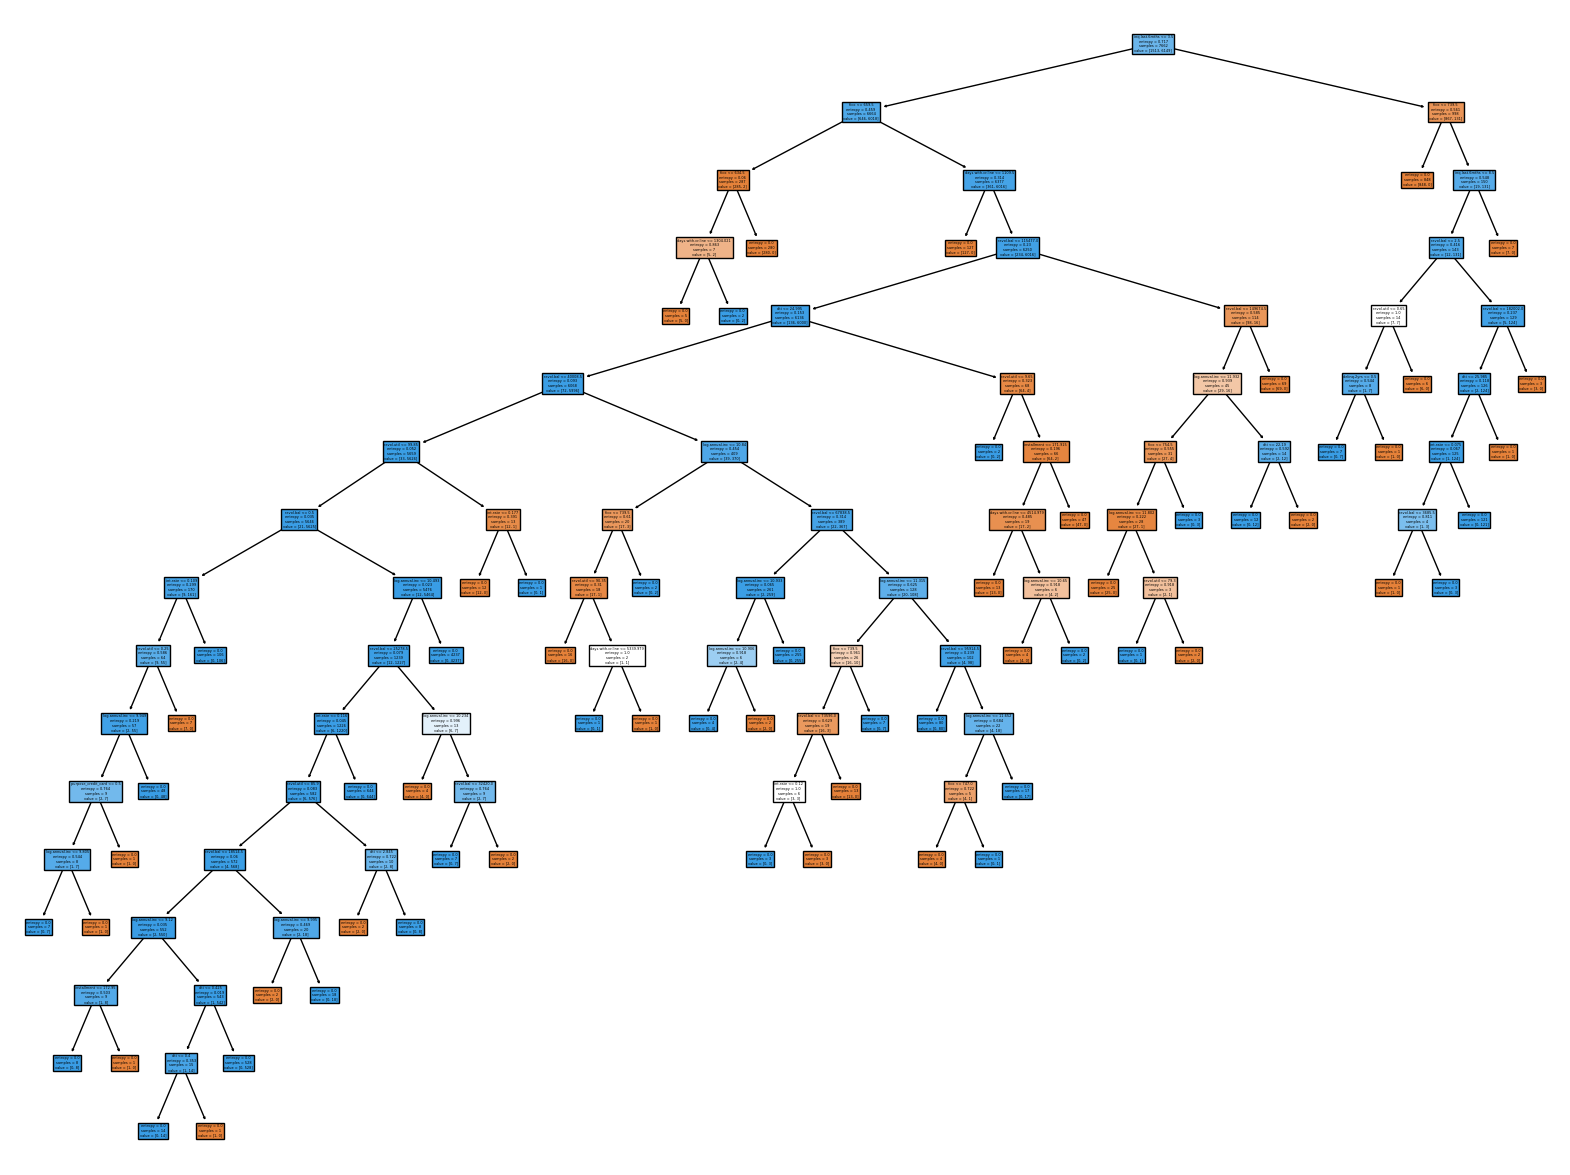

In [34]:
# Initializing a tree with the best parameters for plotting
best_dt = DecisionTreeClassifier().set_params(**grid_dt_clf.best_params_)
best_dt.fit(X_train, y_train)

fig = plt.subplots(figsize=(20, 15))
_ = plot_tree(best_dt, feature_names=feature_labels, filled=True)

### Random Forest:

In [35]:
params = {
    'max_depth': [2*i for i in range(1, 10)],
    'criterion' : ['gini', 'entropy'],
    'max_features' : [None, 'sqrt', 'log2'],
    'n_estimators': [50,100,200,500,1000]
}

rf_clf = RandomForestClassifier()

grid_rf_clf = GridSearchCV(rf_clf, params, cv=5, scoring='accuracy', verbose = 1)

grid_rf_clf.fit(X_train, y_train)

rf_score = grid_rf_clf.score(X_test, y_test)
print("Random Forest Accuracy: {}".format(rf_score))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Random Forest Accuracy: 0.9953027139874739


In [37]:
# Printing best params
print("Best parameters found for the Random Forest: {}".format(grid_rf_clf.best_params_))

Best parameters found for the Random Forest: {'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'n_estimators': 50}


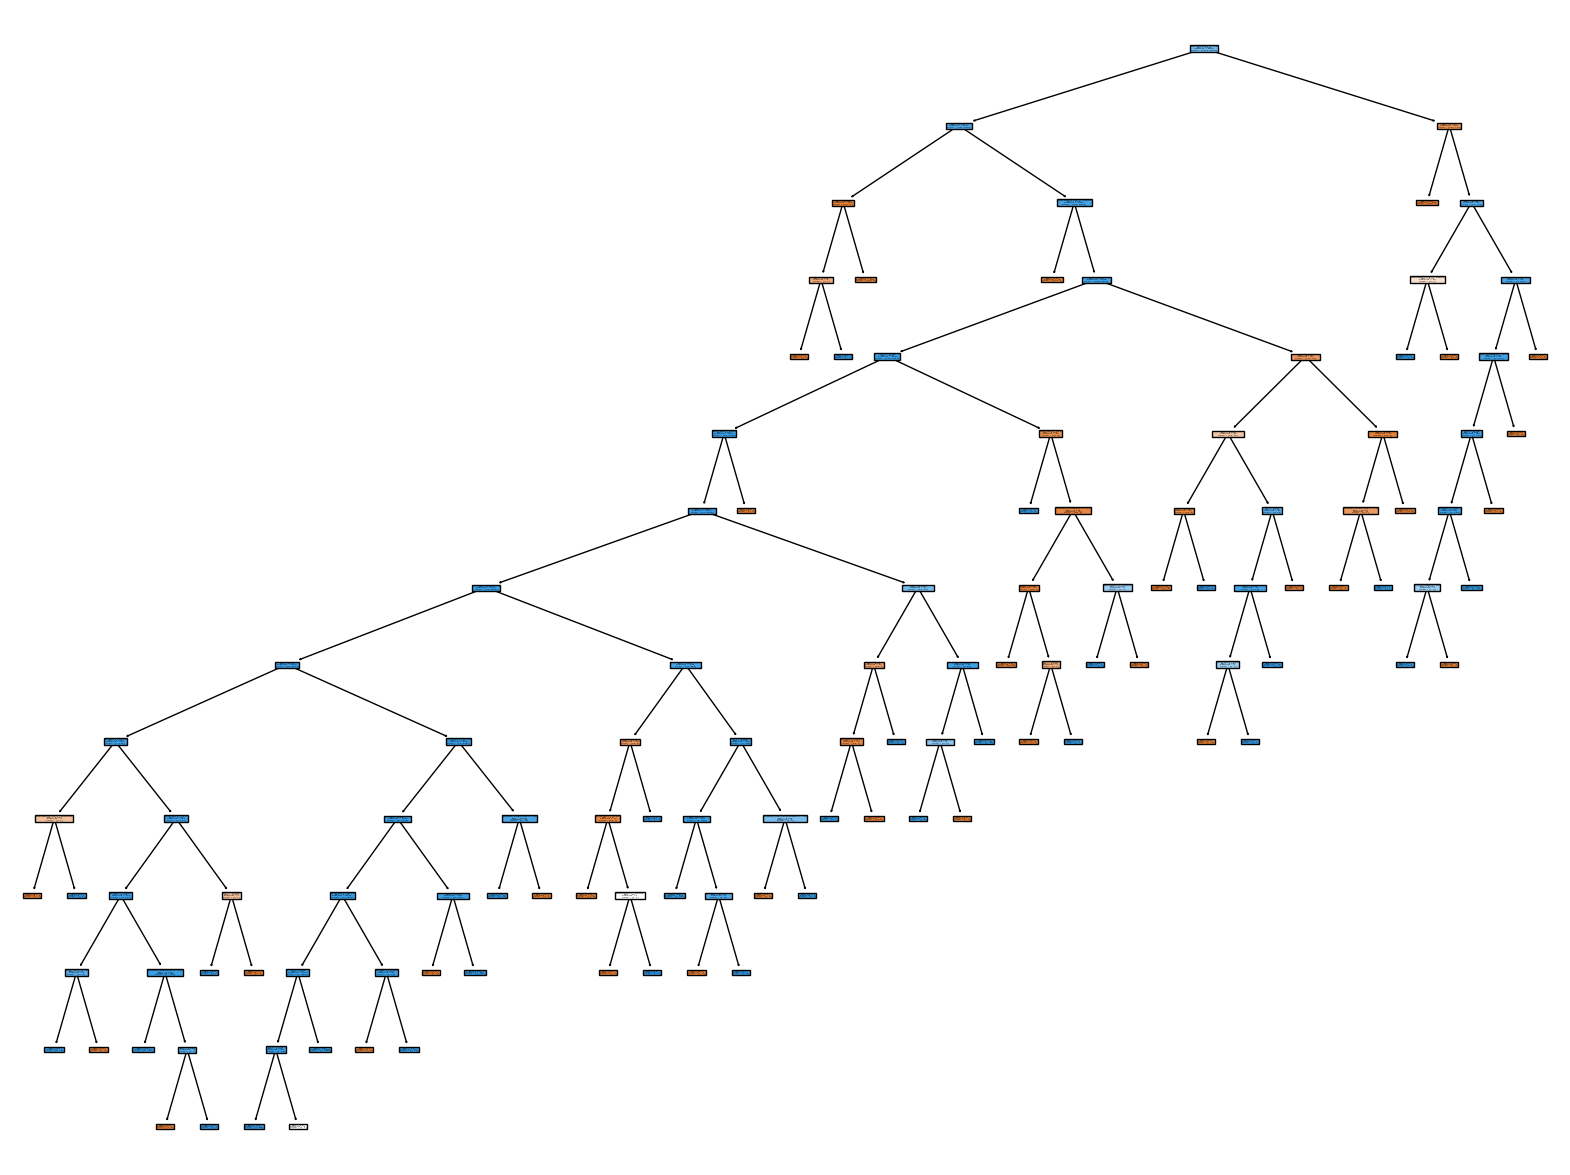

In [38]:
# Initializing a random forest with the best parameters for plotting
best_rf = RandomForestClassifier().set_params(**grid_rf_clf.best_params_)
best_rf.fit(X_train, y_train)

fig = plt.subplots(figsize=(20, 15))
_ = plot_tree(best_rf.estimators_[1], feature_names=feature_labels, filled=True)

### Questions
1. How did the DT compare to the RF in performance? Why?
    - Both models scored extremely high results (99%+), but RF was slightly more accurate. That is because the RF uses multiple DTs and aggregates their predictions into a more accurate one. It can generalize the data better and doesn't depend on a specific set of features since it chooses them randomly during the training process.
    
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - The Max Depth of the RF was higher than that of the DT. That is because the DT uses a bagging technique in which trees are fitted onto random subsets of the original dataset. This method allows each tree to have low variance while the RF maintains the ability to generalize over the dataset.
    
3. What is ensemble learning? What are its pros and cons?
    - **Ensemble Learning** is the idea of combining multiple smaller models into a larger model using specific methods for aggregating their predictions into one, final prediction which is usually more accurate than the individual predictions of the smaller models.
    
    - **Pros**:
        - Reducing bias/variance.
        - Higher accuracy.
        - Improved generalizability / robustness over a single model.
    
    - **Cons**:
        - Computationally expensive.

4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - **Boosting methods**:
    
        - **Adaptive Boosting**: In essence, it is fitting a sequence of weak learners on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote to produce the final prediction. It starts with equal weights for all the training samples, and for each successive iteration, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly.

        - **Gradient Boosting**: It gives a prediction model in the form of an ensemble of weak prediction models. By combining the best next model possible with the previous models, we can increase the accuracy of our predictions.
    
    - **Bagging methods**:
    
        - **Bagging Classifier**: Fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

        - **Random Forest**: Also divides the data into random subsets. The prediction of the ensemble is then given as the averaged prediction of the individual Decision Trees of the RF.
    
    - **Random Forest** is a **Bagging method**.

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [157]:
# Prepping and loading the data

directory = 'svhn'

class SVHNDataset(Dataset):
    def __init__(self, transform=None):

        self.transform = transform

        images = []

        for image_name in os.listdir(directory):
            images.append((os.path.join(directory, image_name), image_name.split('.')[0]))
        
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        item = self.images[index]
        image_path = item[0]

        y_label_text = item[1]
        
        first_num = np.repeat(0, 10)
        first_num[int(y_label_text[0])] = 1
        
        second_num = np.repeat(0, 10)
        second_num[int(y_label_text[1])] = 1

        third_num = np.repeat(0, 10)
        third_num[int(y_label_text[2])] = 1
        
        y_label = np.concatenate((first_num, second_num, third_num), axis=None)
        
        image = plt.imread(image_path)
        y_label = torch.tensor(y_label).float()

        if self.transform:
            image = self.transform(image)
            
        return image, y_label

class Flatten:
    def __init__(self):
        pass
    
    def __call__(self, tensor):
        return torch.flatten(tensor)

data_transformations = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize([84, 84]),
                            transforms.Grayscale(),
                        ])

data_transformations_ANN = transforms.Compose([
                                transforms.ToTensor(),
                                Flatten()
                            ])

# Creating Datasets and Dataloaders
svhn_dataset = SVHNDataset(transform=data_transformations)

svhn_dataloader = DataLoader(svhn_dataset, 13, shuffle=False)

In [158]:
# Evaluating the model

CNN_model = torch.load('./models/best_model_CNN.pt')

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

_, _ = test(model=CNN_model, device=device, test_loader=svhn_dataloader, data_type="Test")

Test set: Average loss: 8.2882925272, Accuracy: 47/276 (17%)



### Questions
1. How did your model perform? Why is it better/worse?
    - The model performed way worse, due to the difference in distribution between the two domains on which we performed our tests (`SVHN` and `MNIST` datasets). The images from the `MNIST` dataset contain clear, handwritten numbers that can be easily distinguished from their single-colored background. Meanwhile, the `SVHN` dataset contain numbers written using various digital fonts written on different, cluttered, multi-colored, and complex backgrounds.
2. What is domain gap in the context of ML?
    - Let's start by defining the difference between domains. Having different domains generally means having different representations of the same data. In our case for example, each element of both of our datasets is in the end, 3 digits, but they are represented differently in each dataset (as explained above). Domain gap, is the simple fact that models trained on data collected in one domain generally have poor accuracy on other domains.
    
3. Suggest two ways through which the problem of domain gap can be tackled.
    - From the research I have done, I can see this problem is still being rearched as I wasn't able to find any conrete or general solutions to it.

    - What we can do in this specific case, in my opinion, is add some data from the other domain to the data we used for training (with some augmentation, of course) in order to increase the variance in our training dataset. Another thing we can do, is transform the images from the `SVHN` dataset to make them look similar to the `MNIST` dataset which should result in better accuracy.

## Resrouces:

- Encoding: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
- Data Loading: Lab 7 - Self Practice
- Training and Testing Loops: Lab 7 - Solution
- Pytorch Docs: https://pytorch.org/docs/stable/index.html
- Loading Image Dataset: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/custom_dataset/custom_dataset.py
- Decision Trees and Random Forest: Labs 10, 11 and 12
- Fine-tuning the Decision Tree: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
- Fine-tuning the Random Forest: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- Saving models: 
    - https://niruhan.medium.com/periodically-save-trained-neural-network-models-in-pytorch-f0837cc867e7
    - https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Calculating speed of inference: https://discuss.pytorch.org/t/how-to-measure-the-executive-time-training-and-inference/58014
- Ensemble Learning: https://scikit-learn.org/stable/modules/ensemble.html
- Bagging Classifier: https://www.geeksforgeeks.org/ml-bagging-classifier/
- Domain Gap: https://machinelearning.apple.com/research/bridging-the-domain-gap-for-neural-models